 # DANN for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np
import pandas as pd


import torch
from torch.nn import functional as F
from torch import nn
from torch.cuda.amp import GradScaler
from torch import autocast

from src.da_models.autoencoder import AutoEncoder
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import load_spatial, get_selected_dir, get_model_rel_path
from src.utils.evaluation import format_iters

# datetime object containing current date and time
script_start_time = datetime.datetime.now(datetime.timezone.utc)


/tmp/ipykernel_2096849/2106691202.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
TORCH_MANUAL_SEED = 2360
CUDA_DEVICE = 3


In [3]:
DATA_DIR = "data"
TRAIN_USING_ALL_ST_SAMPLES = False
N_MARKERS = 20
ALL_GENES = False

ST_SPLIT = True

SCALER_NAME = "standard"
SAMPLE_ID_N = "151673"

MODEL_NAME = "Autoencoder_st"
MODEL_VERSION = "V1"

autoencoder_kwargs = {
    "emb_dim": 64,
    "dropout": 0.1,
    "enc_out_act": None,
    "dec_out_act": None,
    "bn_momentum": 0.1
}

BATCH_SIZE = 64
NUM_WORKERS = 8
INITIAL_TRAIN_LR = 0.002
INITIAL_TRAIN_EPOCHS = 400

MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

adamw_kwargs = {"lr": INITIAL_TRAIN_LR, "weight_decay": 1.0}

# Validation using MSE Loss function
criterion = torch.nn.MSELoss()
# def log_target_pnll_loss(input, target, **kwargs):
#     return F.poisson_nll_loss(input, torch.exp(target), log_input=True, full=True, **kwargs)
# criterion = log_target_pnll_loss
# criterion = torch.nn.PoissonNLLLoss(log_input=True, full=True)

In [4]:
if CUDA_DEVICE:
    device = torch.device(f"cuda:{CUDA_DEVICE}" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)

if TORCH_MANUAL_SEED or TORCH_MANUAL_SEED == 0:
    torch_seed = TORCH_MANUAL_SEED
    torch_seed_path = str(TORCH_MANUAL_SEED)
else:
    torch_seed = int(script_start_time.timestamp())
    torch_seed_path = script_start_time.strftime("%Y-%m-%d_%Hh%Mm%Ss")

torch.manual_seed(torch_seed)
np.random.seed(torch_seed)

model_folder = get_model_rel_path(
    MODEL_NAME,
    MODEL_VERSION,
    scaler_name=SCALER_NAME,
    n_markers=N_MARKERS,
    all_genes=ALL_GENES,
    # n_mix=N_MIX,
    # n_spots=N_SPOTS,
    st_split=ST_SPLIT,
    torch_seed_path=torch_seed_path,
)
model_folder = os.path.join("model", model_folder)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)



model/Autoencoder_st/20markers/standard/8mix_20000spots_stsplit/V1/2360


 # Data load

In [5]:
# # # Load spatial data
# mat_sp_train_s_d = {}
# if ST_SPLIT:
#     mat_sp_val_s_d = {}
#     mat_sp_test_s_d = {}
#     with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_split_s_d.hdf5"), "r") as f:
#         for sample_id in f:
#             mat_sp_train_s_d[sample_id] = f[f"{sample_id}/train"][()]
#             mat_sp_val_s_d[sample_id] = f[f"{sample_id}/val"][()]
#             mat_sp_test_s_d[sample_id] = f[f"{sample_id}/test"][()]
# else:
#     with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s_d.hdf5"), "r") as f:
#         for sample_id in f:
#             mat_sp_train_s_d[sample_id] = f[sample_id][()]

# if TRAIN_USING_ALL_ST_SAMPLES:
#     with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
#         mat_sp_train_s = f["all"][()]
# else:
#     mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
# with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
#     sc_mix_train_s = f["X/train"][()]
#     sc_mix_val_s = f["X/val"][()]
#     sc_mix_test_s = f["X/test"][()]

#     lab_mix_train = f["y/train"][()]
#     lab_mix_val = f["y/val"][()]
#     lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
# Load sc data
mat_sp_d, mat_sp_train, st_sample_id_l = load_spatial(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    train_using_all_st_samples=TRAIN_USING_ALL_ST_SAMPLES,
    st_split=ST_SPLIT,
)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [6]:
### source dataloaders
# source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
# source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
# source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

# dataloader_source_train = torch.utils.data.DataLoader(
#     source_train_set,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS,
#     pin_memory=False,
# )
# dataloader_source_val = torch.utils.data.DataLoader(
#     source_val_set,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=False,
# )
# dataloader_source_test = torch.utils.data.DataLoader(
#     source_test_set,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=False,
# )

### target dataloaders
target_train_set_d = {}
dataloader_target_train_d = {}
if ST_SPLIT:
    target_val_set_d = {}
    target_test_set_d = {}

    dataloader_target_val_d = {}
    dataloader_target_test_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        target_val_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["val"])
        target_test_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["test"])

        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_val_d[sample_id] = torch.utils.data.DataLoader(
            target_val_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

else:
    target_test_set_d = {}
    dataloader_target_test_d = {}

    target_train_set_dis_d = {}
    dataloader_target_train_dis_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_test_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["test"])
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_train_set_dis_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["train"])
        )
        dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_dis_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

# if TRAIN_USING_ALL_ST_SAMPLES:
#     target_train_set = SpotDataset(mat_sp_train_s)
#     dataloader_target_train = torch.utils.data.DataLoader(
#         target_train_set,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )
#     target_train_set_dis = SpotDataset(deepcopy(mat_sp_train_s))
#     dataloader_target_train_dis = torch.utils.data.DataLoader(
#         target_train_set_dis,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )
# else:
#     target_train_set_d = {}
#     dataloader_target_train_d = {}

#     target_train_set_dis_d = {}
#     dataloader_target_train_dis_d = {}
#     for sample_id in st_sample_id_l:
#         target_train_set_d[sample_id] = SpotDataset(
#             deepcopy(mat_sp_test_s_d[sample_id])
#         )
#         dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
#             target_train_set_d[sample_id],
#             batch_size=BATCH_SIZE,
#             shuffle=True,
#             num_workers=NUM_WORKERS,
#             pin_memory=False,
#         )

#         target_train_set_dis_d[sample_id] = SpotDataset(
#             deepcopy(mat_sp_test_s_d[sample_id])
#         )
#         dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
#             target_train_set_dis_d[sample_id],
#             batch_size=BATCH_SIZE,
#             shuffle=True,
#             num_workers=NUM_WORKERS,
#             pin_memory=False,
#         )


In [7]:
# import itertools


# def plot_iters(nested_list, startpoint=False, endpoint=True, ax=None, **kwargs):
#     if ax is None:
#         ax = plt

#     x = []
#     if startpoint:
#         for i, l in enumerate(nested_list):
#             if endpoint and i == len(nested_list) - 1:
#                 x_i = np.linspace(i - 1, i, len(l), endpoint=True, dtype=np.float32)
#             else:
#                 x_i = np.linspace(i - 1, i, len(l), endpoint=False, dtype=np.float32)
#             x.append(x_i)
#     else:
#         for i, l in enumerate(nested_list):
#             if not endpoint and i == len(nested_list) - 1:
#                 x_i = np.linspace(
#                     i, i - 1, len(l + 1), endpoint=False, dtype=np.float32
#                 )
#                 x_i = x_i[1:]
#             else:
#                 x_i = np.linspace(i, i - 1, len(l), endpoint=False, dtype=np.float32)

#             # Flip to not include startpoint i.e. shift to end of iteration
#             x_i = np.flip(x_i)
#             x.append(x_i)

#     x = np.asarray(list(itertools.chain(*x)))
#     y = np.asarray(list(itertools.chain(*nested_list)))
#     ax.plot(x, y, **kwargs)

#     return x, y


In [8]:
def pred_loss(model, x):
    x_pred = model(x)
    loss = criterion(x_pred, x)
    if not isinstance(criterion, nn.MSELoss):
        mse = F.mse_loss(x_pred.detach(), x)
    else:
        mse = loss
    return x_pred, loss, mse


def run_epoch(
    dataloader,
    model,
    optimizer=None,
    scheduler=None,
    scaler=None,
    inner=None,
    predict=False,
):
    """Runs a single epoch of training or validation."""
    running_results = {}
    running_results["loss"] = []
    running_results["mse"] = []
    running_results["bs"] = []
    if scheduler is not None:
        running_results["lr"] = []
    if predict:
        running_results["pred"] = []
        running_results["true"] = []
    for _, (x, _) in enumerate(dataloader):
        if scheduler is not None:
            running_results["lr"].append(scheduler.get_last_lr()[-1])
        if optimizer is not None:
            optimizer.zero_grad()

        x = x.to(torch.float32).to(device)

        if scaler is not None:
            with autocast(device_type=device.type, dtype=torch.float16):
                x_pred, loss, mse = pred_loss(model, x)
        else:
            x_pred, loss, mse = pred_loss(model, x)
                

        running_results["loss"].append(loss.item())
        running_results["mse"].append(mse.item())
        # we will weight average by batch size later
        running_results["bs"].append(len(x))
        if predict:
            running_results["pred"].append(x_pred.detach().cpu().numpy())
            running_results["true"].append(x.detach().cpu().numpy())

        if scaler is not None:
            if optimizer is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)

            scale = scaler.get_scale()
            scaler.update()

            if scheduler is not None:
                skip_lr_sched = scale > scaler.get_scale()
                if not skip_lr_sched:
                    scheduler.step()
        else:
            if optimizer is not None:
                loss.backward()
                optimizer.step()
            if scheduler is not None:
                scheduler.step()
                
        if inner is not None:
            inner.update(1)

    # Weight average the loss by batch size
    avg_results = {}
    for results in running_results:
        avg_results[results] = np.average(
            running_results[results], weights=running_results["bs"]
        )

    return avg_results, running_results



In [9]:
def train(
    model,
    save_folder,
    dataloader_train,
    dataloader_val,
    epochs=10,
    **adamw_kwargs,
):
    model.to(device)
    
    # AMP Scaler
    scaler = GradScaler()

    optimizer = torch.optim.AdamW(model.parameters(), **adamw_kwargs)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=optimizer.state_dict()["param_groups"][0]["lr"],
        steps_per_epoch=len(dataloader_train),
        epochs=epochs,
    )
    # Initialize lists to store loss and accuracy values
    results_history_running = {}
    results_history = {}
    results_history_val = {}

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0

    # Train
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        print("Start train...")
        outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
        inner = tqdm(total=len(dataloader_train), desc=f"Batch", position=1)

        print(
            " Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    "
        )
        print(
            "------------------------------------------------------------------------"
        )
        checkpoint = {
            "epoch": -1,
            "model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
            "scaler": scaler,
        }
        for epoch in range(INITIAL_TRAIN_EPOCHS):
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            inner.refresh()  # force print final state
            inner.reset()  # reuse bar

            avg_results, running_results = run_epoch(
                dataloader_train,
                model,
                optimizer=optimizer,
                scheduler=scheduler,
                scaler=scaler,
                inner=inner,
            )

            for k in avg_results:
                try:
                    results_history[k].append(avg_results[k])
                except KeyError:
                    results_history[k] = [avg_results[k]]
            for k in running_results:
                try:
                    results_history_running[k].append(running_results[k])
                except KeyError:
                    results_history_running[k] = [running_results[k]]

            # Evaluate mode
            model.eval()
            with torch.no_grad():
                avg_results_val, running_results_val = run_epoch(
                    dataloader_val, model
                )
            for k in avg_results_val:
                try:
                    results_history_val[k].append(avg_results_val[k])
                except KeyError:
                    results_history_val[k] = [avg_results_val[k]]

            # Print the results
            outer.update(1)
            print(
                f" {epoch:5d}",
                f"| {avg_results['loss']:<10.8f}",
                f"| {avg_results['mse']:<10.8f}",
                f"| {avg_results_val['loss']:<10.8f}",
                f"| {avg_results_val['mse']:<10.8f}",
                f"| {scheduler.get_last_lr()[-1]:<10.5}",
                end=" ",
            )

            # Save the best weights
            if avg_results_val["loss"] < best_loss_val:
                best_loss_val = avg_results_val["loss"]
                torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
                early_stop_count = 0

                print("<-- new best val loss")
            else:
                print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
                torch.save(
                    checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth")
                )

            # check to see if validation loss has plateau'd
            if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
                print(
                    f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(save_folder, f"earlystop{epoch}.pth")
                )
                break

            early_stop_count += 1

    results_history_running["lr"][-1].append(scheduler.get_last_lr()[-1])

    # Save final model
    best_checkpoint = torch.load(os.path.join(save_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(save_folder, f"final_model.pth"))

    results_history_out = {
        "train": {"avg": results_history, "running": results_history_running},
        "val": {"avg": results_history_val},
    }
    # Save results
    with open(os.path.join(save_folder, f"results_history_out.pkl"), "wb") as f:
        pickle.dump(results_history_out, f)

    return results_history_out


In [10]:
def plot_results(train_history_running, val_history, best_epoch, save_folder=None):
    best_loss_val = val_history["loss"][best_epoch]
    best_mse_val = val_history["mse"][best_epoch]

    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 8), layout="constrained")

    x_text = best_epoch + (2 if best_epoch < len(val_history["loss"]) * 0.75 else -2)
    ha_text = "left" if best_epoch < len(val_history["loss"]) * 0.75 else "right"

    axs[0].plot(
        *(x_y_loss_iters := format_iters(train_history_running["loss"])),
        label="Training",
        linewidth=0.5,
    )
    axs[0].plot(val_history["loss"], label="Validation")
    axs[0].axvline(best_epoch, color="tab:green")

    axs[0].set_ylim(bottom=0)
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)

    axs[0].text(
        x=x_text,
        y=max(*x_y_loss_iters[1], *val_history["loss"]) * 0.5,
        s=f"Best val. loss:\n{best_loss_val:.4f} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )

    axs[0].set_title("Loss")
    axs[0].legend()

    # MSE loss
    axs[1].plot(
        *(x_y_mse_iters := format_iters(train_history_running["mse"])),
        label="Training",
        linewidth=0.5,
    )
    axs[1].plot(val_history["mse"], label="Validation")
    axs[1].axvline(best_epoch, ymax=2, clip_on=False, color="tab:green")

    axs[1].set_ylim(bottom=0)
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)

    axs[1].text(
        x=x_text,
        y=max(*x_y_mse_iters[1], *val_history["mse"]) * 0.5,
        s=f"Val. mse:\n{best_mse_val:.4f} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )

    axs[1].set_title("MSE")
    axs[1].legend()

    # lr history
    iters_by_epoch, lr_history_running_flat = format_iters(
        train_history_running["lr"], startpoint=True
    )
    axs[2].plot(iters_by_epoch, lr_history_running_flat)
    axs[2].axvline(best_epoch, ymax=2, clip_on=False, color="tab:green")

    axs[2].set_ylim(bottom=0)
    axs[2].grid(which="major")
    axs[2].minorticks_on()
    axs[2].grid(which="minor", alpha=0.2)

    best_epoch_idx = np.where(iters_by_epoch == best_epoch)[0][0]
    axs[2].text(
        x=x_text,
        y=np.median(lr_history_running_flat),
        s=f"LR:\n{lr_history_running_flat[best_epoch_idx]:.4} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )

    axs[2].set_xlabel("Epoch")
    axs[2].set_title("Learning Rate")

    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        plt.savefig(os.path.join(save_folder, "train_plots.png"), bbox_inches="tight")
    plt.show(block=False)

Training on sample 151507
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/53 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.75163967 | 1.75163967 | 1.29503710 | 1.29503710 | 8.0329e-05 <-- new best val loss
     1 | 1.51089937 | 1.51089937 | 1.18857713 | 1.18857713 | 8.1316e-05 <-- new best val loss
     2 | 1.38367974 | 1.38367974 | 1.12046117 | 1.12046117 | 8.296e-05  <-- new best val loss
     3 | 1.29642177 | 1.29642177 | 1.07601966 | 1.07601966 | 8.5261e-05 <-- new best val loss
     4 | 1.22444371 | 1.22444371 | 1.03415427 | 1.03415427 | 8.8216e-05 <-- new best val loss
     5 | 1.16860784 | 1.16860784 | 1.00062807 | 1.00062807 | 9.1823e-05 <-- new best val loss
     6 | 1.12311833 | 1.12311833 | 0.97714051 | 0.97714051 | 9.608e-05  <-- new best val loss
     7 | 1.08309982 | 1.08309982 | 0.95985226 | 0.95985226 | 0.00010098 <-- new best val loss
     8 | 1.05001868 | 1.05001868 | 0.94439859 | 0.94439859 | 0.00010653 <-- new best val loss
     9 |

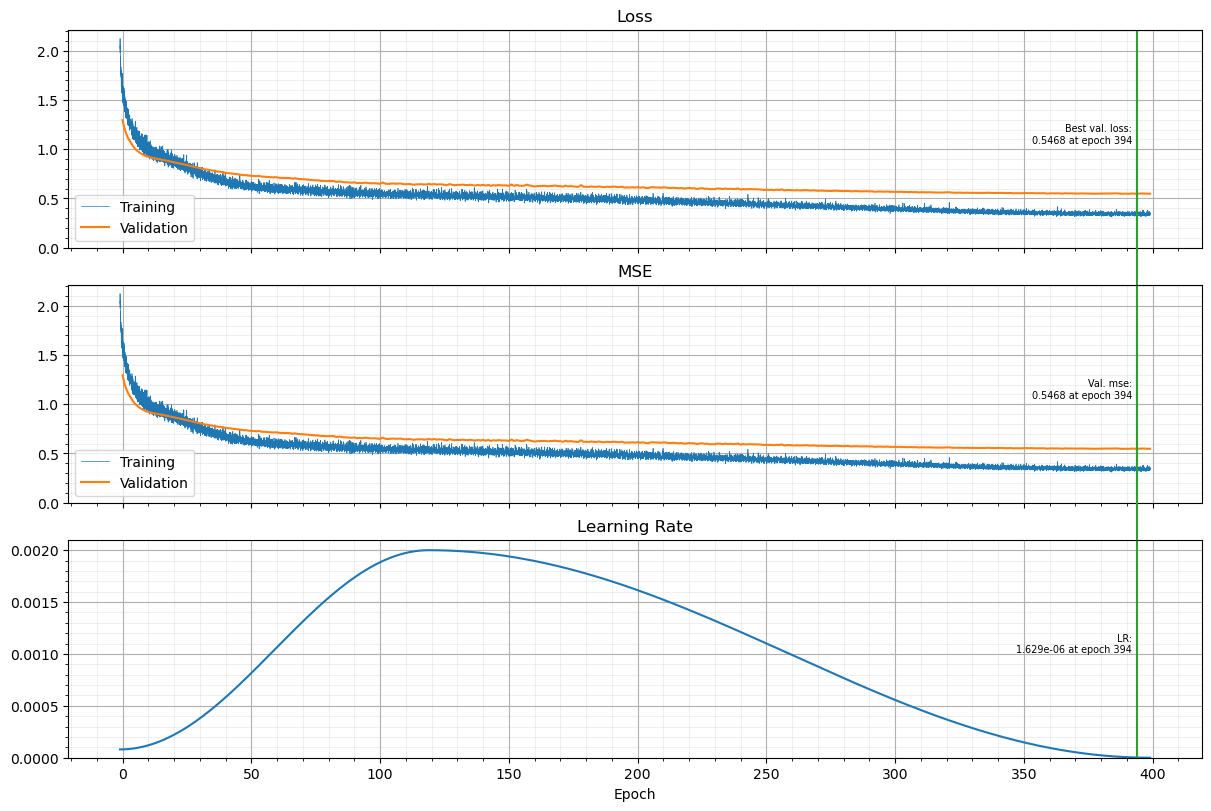

Training on sample 151508
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/55 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.75070316 | 1.75070316 | 1.38695129 | 1.38695129 | 8.0329e-05 <-- new best val loss
     1 | 1.52462932 | 1.52462932 | 1.27632606 | 1.27632606 | 8.1316e-05 <-- new best val loss
     2 | 1.39450425 | 1.39450425 | 1.19721896 | 1.19721896 | 8.296e-05  <-- new best val loss
     3 | 1.30687386 | 1.30687386 | 1.14988028 | 1.14988028 | 8.5261e-05 <-- new best val loss
     4 | 1.23953656 | 1.23953656 | 1.10952076 | 1.10952076 | 8.8215e-05 <-- new best val loss
     5 | 1.18706078 | 1.18706078 | 1.07610438 | 1.07610438 | 9.1823e-05 <-- new best val loss
     6 | 1.13951879 | 1.13951879 | 1.04760915 | 1.04760915 | 9.608e-05  <-- new best val loss
     7 | 1.10108433 | 1.10108433 | 1.02978145 | 1.02978145 | 0.00010098 <-- new best val loss
     8 | 1.06833822 | 1.06833822 | 1.00960541 | 1.00960541 | 0.00010653 <-- new best val loss
     9 |

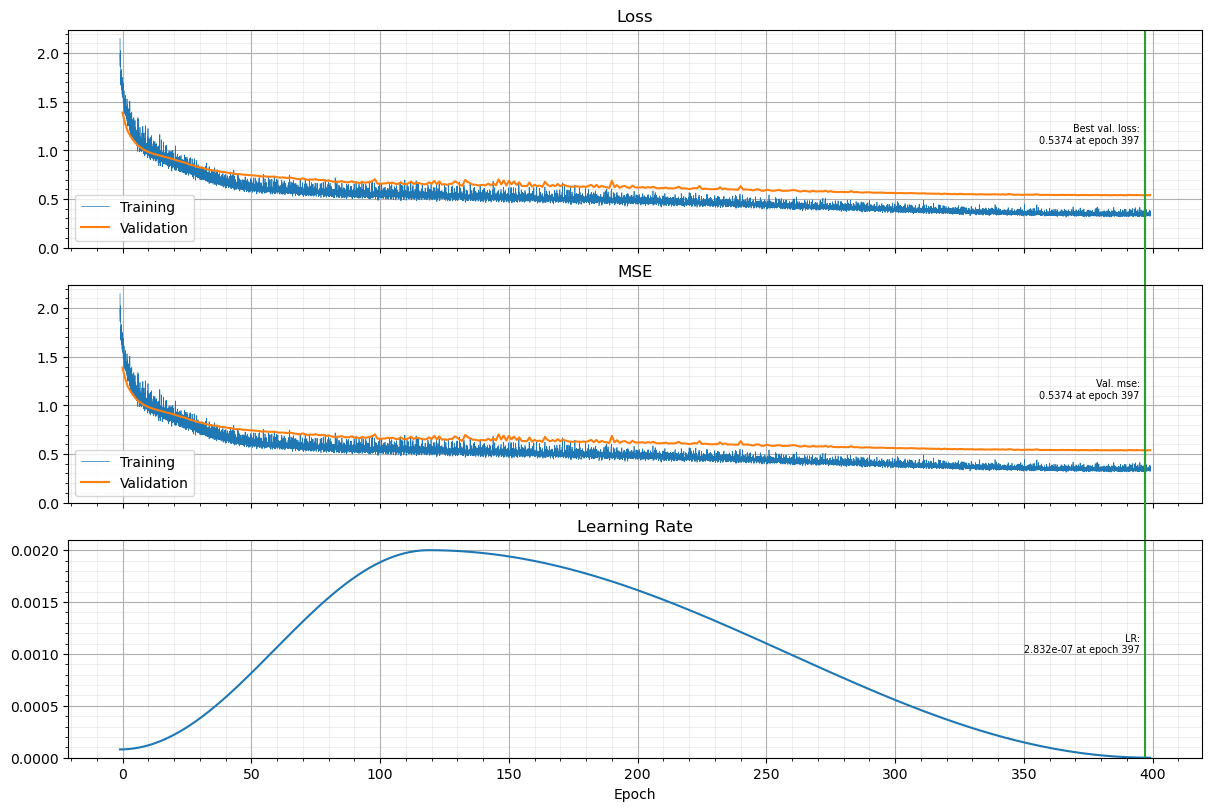

Training on sample 151509
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/60 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.73817520 | 1.73817520 | 1.28236622 | 1.28236622 | 8.0329e-05 <-- new best val loss
     1 | 1.48754204 | 1.48754204 | 1.17443820 | 1.17443820 | 8.1316e-05 <-- new best val loss
     2 | 1.35461645 | 1.35461645 | 1.10521820 | 1.10521820 | 8.296e-05  <-- new best val loss
     3 | 1.26257714 | 1.26257714 | 1.06060949 | 1.06060949 | 8.526e-05  <-- new best val loss
     4 | 1.19043445 | 1.19043445 | 1.01605469 | 1.01605469 | 8.8215e-05 <-- new best val loss
     5 | 1.13444791 | 1.13444791 | 0.99005399 | 0.99005399 | 9.1822e-05 <-- new best val loss
     6 | 1.09071203 | 1.09071203 | 0.96725216 | 0.96725216 | 9.608e-05  <-- new best val loss
     7 | 1.05672150 | 1.05672150 | 0.95189371 | 0.95189371 | 0.00010098 <-- new best val loss
     8 | 1.02829126 | 1.02829126 | 0.93974461 | 0.93974461 | 0.00010653 <-- new best val loss
     9 |

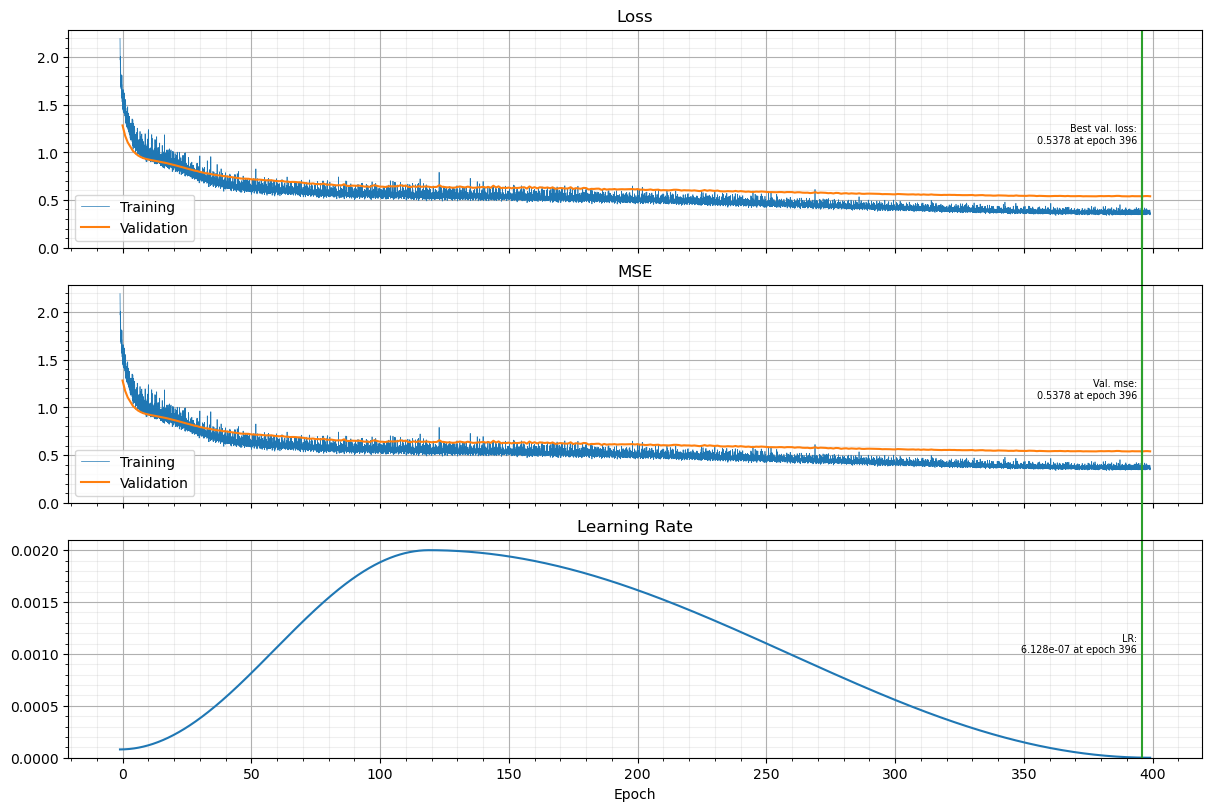

Training on sample 151510
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/58 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.75741743 | 1.75741743 | 1.29880427 | 1.29880427 | 8.0329e-05 <-- new best val loss
     1 | 1.51689228 | 1.51689228 | 1.20572941 | 1.20572941 | 8.1316e-05 <-- new best val loss
     2 | 1.38772606 | 1.38772606 | 1.13691536 | 1.13691536 | 8.296e-05  <-- new best val loss
     3 | 1.30013803 | 1.30013803 | 1.08283177 | 1.08283177 | 8.526e-05  <-- new best val loss
     4 | 1.23231546 | 1.23231546 | 1.04811481 | 1.04811481 | 8.8215e-05 <-- new best val loss
     5 | 1.17650921 | 1.17650921 | 1.01766545 | 1.01766545 | 9.1823e-05 <-- new best val loss
     6 | 1.12914568 | 1.12914568 | 0.99819583 | 0.99819583 | 9.608e-05  <-- new best val loss
     7 | 1.08833292 | 1.08833292 | 0.97124305 | 0.97124305 | 0.00010098 <-- new best val loss
     8 | 1.05474146 | 1.05474146 | 0.95786932 | 0.95786932 | 0.00010653 <-- new best val loss
     9 |

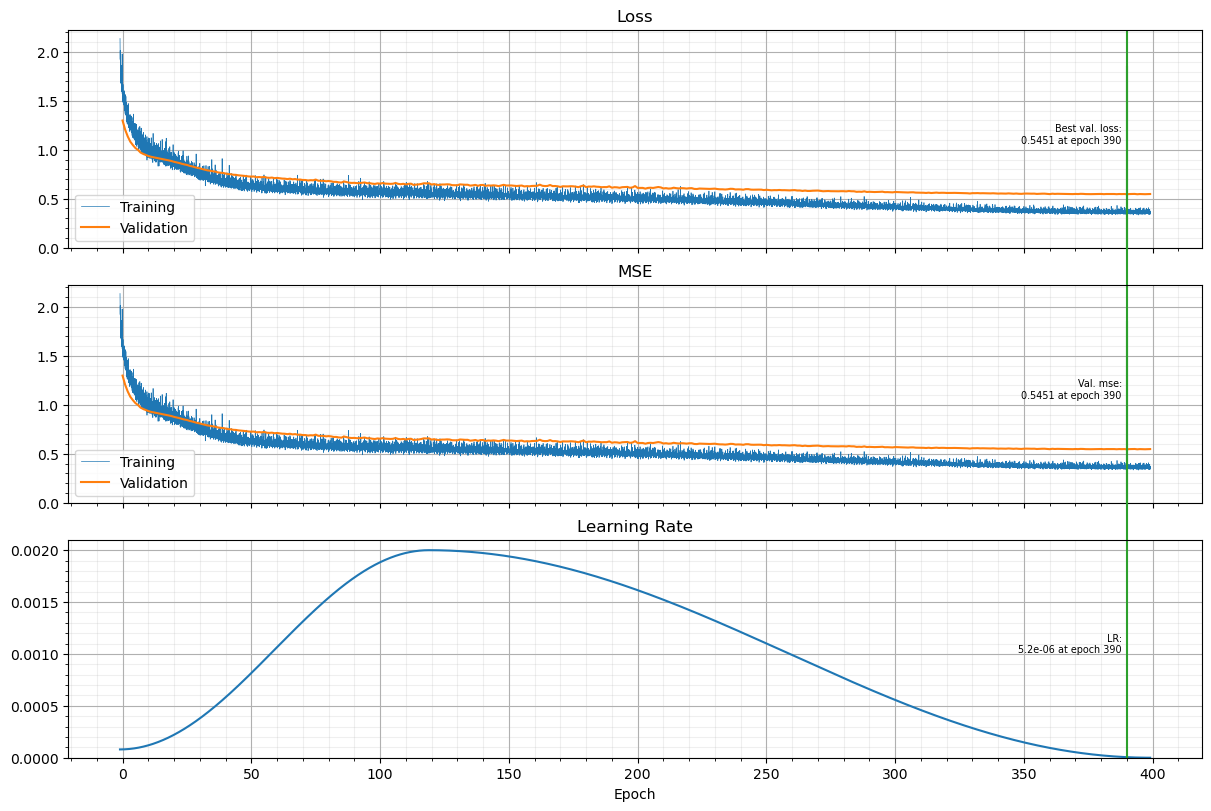

Training on sample 151669
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/46 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.77053495 | 1.77053495 | 1.39893608 | 1.39893608 | 8.0329e-05 <-- new best val loss
     1 | 1.55958468 | 1.55958468 | 1.29906929 | 1.29906929 | 8.1316e-05 <-- new best val loss
     2 | 1.44357568 | 1.44357568 | 1.22952638 | 1.22952638 | 8.296e-05  <-- new best val loss
     3 | 1.35798574 | 1.35798574 | 1.17979291 | 1.17979291 | 8.5261e-05 <-- new best val loss
     4 | 1.29377083 | 1.29377083 | 1.14397305 | 1.14397305 | 8.8216e-05 <-- new best val loss
     5 | 1.24124014 | 1.24124014 | 1.10629828 | 1.10629828 | 9.1823e-05 <-- new best val loss
     6 | 1.19860524 | 1.19860524 | 1.08407562 | 1.08407562 | 9.6081e-05 <-- new best val loss
     7 | 1.15950257 | 1.15950257 | 1.05799149 | 1.05799149 | 0.00010099 <-- new best val loss
     8 | 1.12528929 | 1.12528929 | 1.04330965 | 1.04330965 | 0.00010653 <-- new best val loss
     9 |

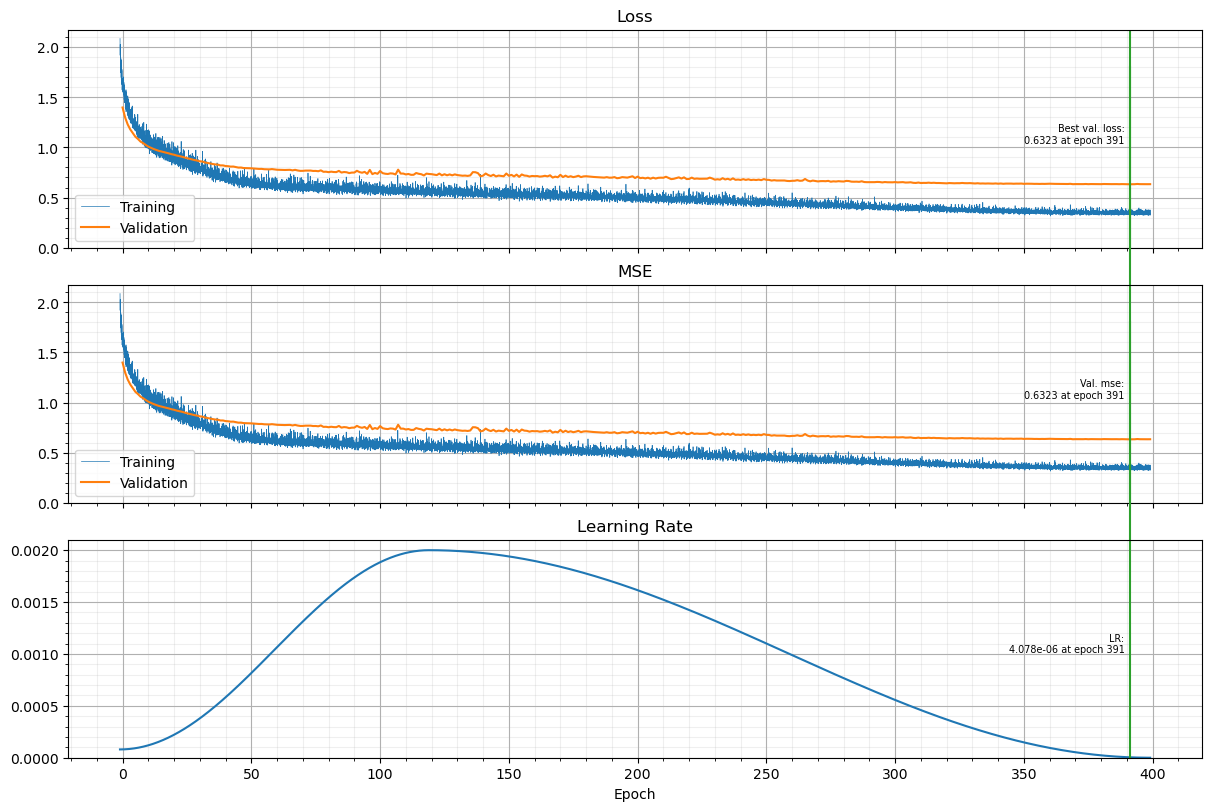

Training on sample 151670
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.78562658 | 1.78562658 | 1.27753998 | 1.27753998 | 8.0329e-05 <-- new best val loss
     1 | 1.56882349 | 1.56882349 | 1.18161977 | 1.18161977 | 8.1316e-05 <-- new best val loss
     2 | 1.45088551 | 1.45088551 | 1.11719455 | 1.11719455 | 8.296e-05  <-- new best val loss
     3 | 1.36309854 | 1.36309854 | 1.07086975 | 1.07086975 | 8.5261e-05 <-- new best val loss
     4 | 1.29865135 | 1.29865135 | 1.04547938 | 1.04547938 | 8.8216e-05 <-- new best val loss
     5 | 1.24629143 | 1.24629143 | 1.01205110 | 1.01205110 | 9.1824e-05 <-- new best val loss
     6 | 1.19954951 | 1.19954951 | 0.99004663 | 0.99004663 | 9.6081e-05 <-- new best val loss
     7 | 1.15869268 | 1.15869268 | 0.97075893 | 0.97075893 | 0.00010099 <-- new best val loss
     8 | 1.12359272 | 1.12359272 | 0.95088857 | 0.95088857 | 0.00010653 <-- new best val loss
     9 |

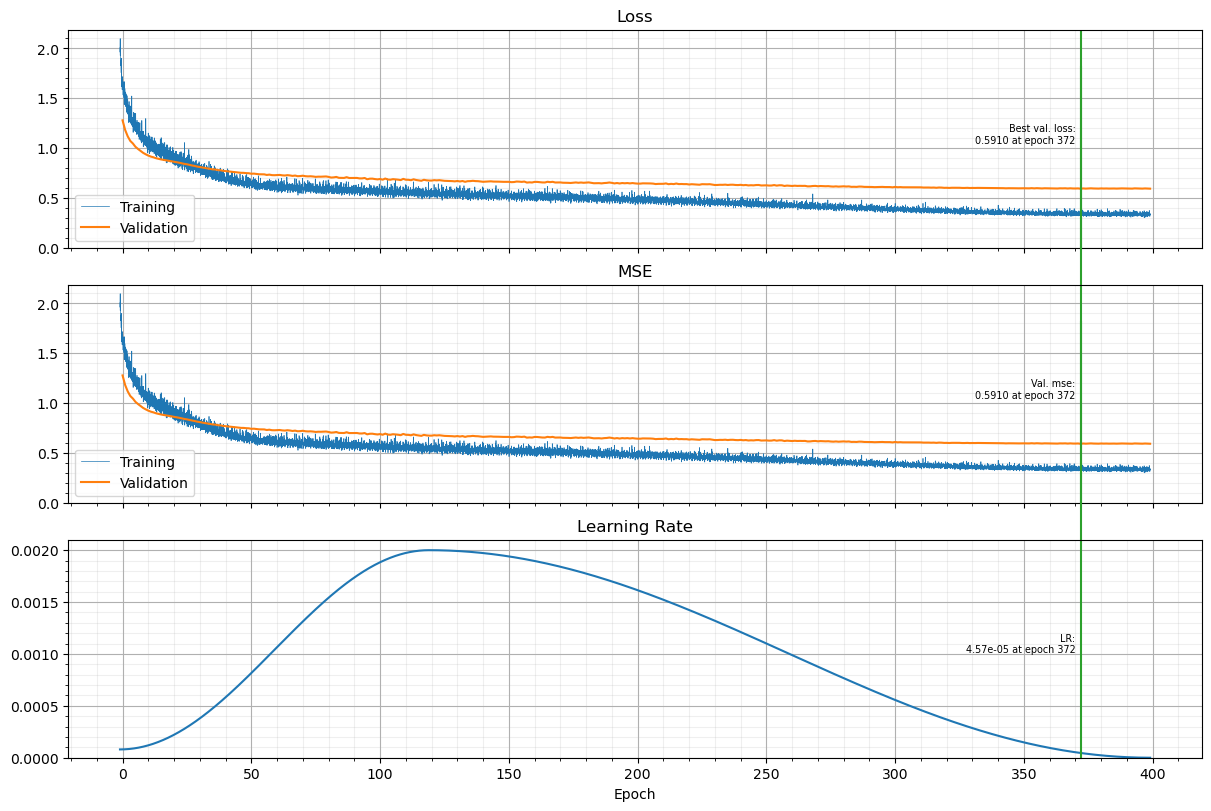

Training on sample 151671
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/52 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.76453483 | 1.76453483 | 1.28736635 | 1.28736635 | 8.0329e-05 <-- new best val loss
     1 | 1.52412943 | 1.52412943 | 1.17541295 | 1.17541295 | 8.1316e-05 <-- new best val loss
     2 | 1.39275466 | 1.39275466 | 1.10867936 | 1.10867936 | 8.296e-05  <-- new best val loss
     3 | 1.29618813 | 1.29618813 | 1.05302356 | 1.05302356 | 8.5261e-05 <-- new best val loss
     4 | 1.22144950 | 1.22144950 | 1.01896343 | 1.01896343 | 8.8216e-05 <-- new best val loss
     5 | 1.15949833 | 1.15949833 | 0.98067597 | 0.98067597 | 9.1823e-05 <-- new best val loss
     6 | 1.11057371 | 1.11057371 | 0.95673367 | 0.95673367 | 9.608e-05  <-- new best val loss
     7 | 1.06776238 | 1.06776238 | 0.94023555 | 0.94023555 | 0.00010099 <-- new best val loss
     8 | 1.03878859 | 1.03878859 | 0.92968817 | 0.92968817 | 0.00010653 <-- new best val loss
     9 |

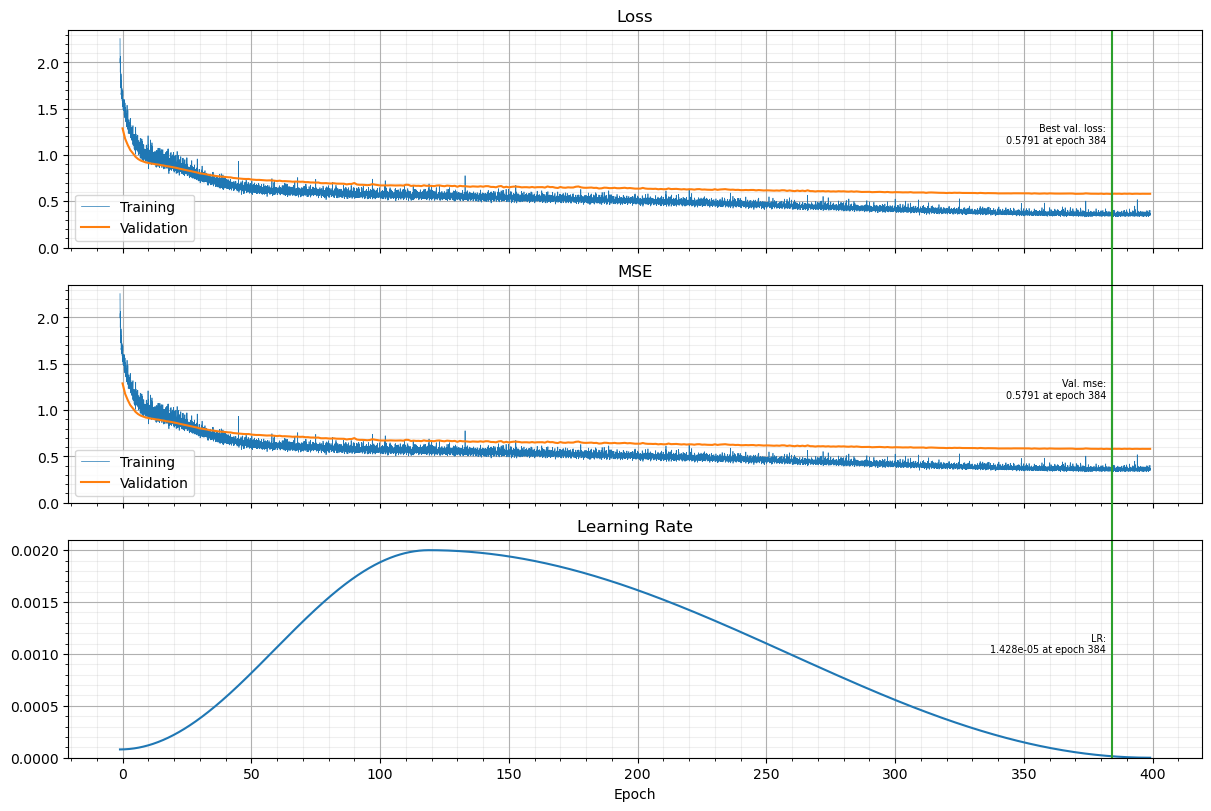

Training on sample 151672
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/51 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.78442258 | 1.78442258 | 1.37402074 | 1.37402074 | 8.0329e-05 <-- new best val loss
     1 | 1.54091538 | 1.54091538 | 1.26009388 | 1.26009388 | 8.1316e-05 <-- new best val loss
     2 | 1.40677590 | 1.40677590 | 1.18425143 | 1.18425143 | 8.296e-05  <-- new best val loss
     3 | 1.31177324 | 1.31177324 | 1.13036901 | 1.13036901 | 8.5261e-05 <-- new best val loss
     4 | 1.23715703 | 1.23715703 | 1.08931959 | 1.08931959 | 8.8216e-05 <-- new best val loss
     5 | 1.17764997 | 1.17764997 | 1.05149663 | 1.05149663 | 9.1823e-05 <-- new best val loss
     6 | 1.12596692 | 1.12596692 | 1.02902278 | 1.02902278 | 9.6081e-05 <-- new best val loss
     7 | 1.08270011 | 1.08270011 | 1.00960442 | 1.00960442 | 0.00010099 <-- new best val loss
     8 | 1.05191402 | 1.05191402 | 0.99426259 | 0.99426259 | 0.00010653 <-- new best val loss
     9 |

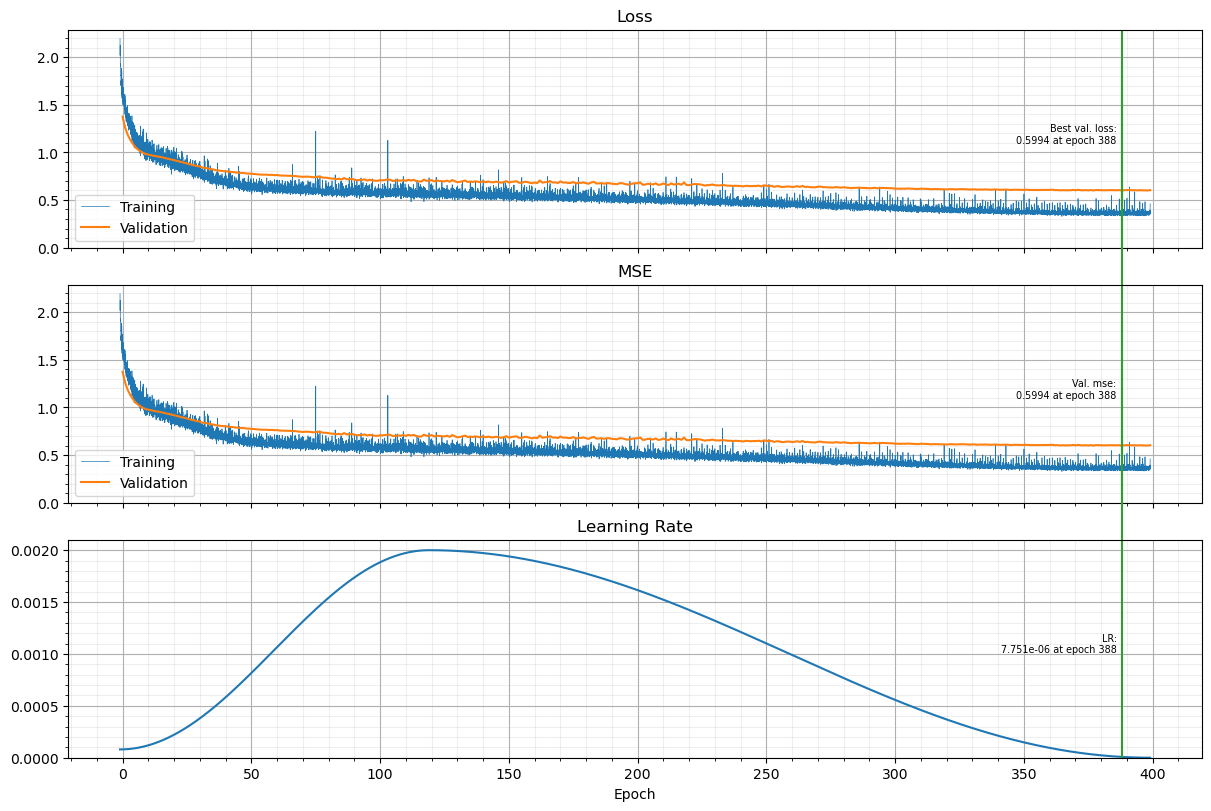

Training on sample 151673
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/46 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.77134119 | 1.77134119 | 1.29594375 | 1.29594375 | 8.0329e-05 <-- new best val loss
     1 | 1.51021946 | 1.51021946 | 1.17909772 | 1.17909772 | 8.1316e-05 <-- new best val loss
     2 | 1.37287374 | 1.37287374 | 1.09771689 | 1.09771689 | 8.296e-05  <-- new best val loss
     3 | 1.27318222 | 1.27318222 | 1.05345454 | 1.05345454 | 8.5261e-05 <-- new best val loss
     4 | 1.19505988 | 1.19505988 | 1.00628087 | 1.00628087 | 8.8216e-05 <-- new best val loss
     5 | 1.13263472 | 1.13263472 | 0.97484399 | 0.97484399 | 9.1823e-05 <-- new best val loss
     6 | 1.08588949 | 1.08588949 | 0.95050284 | 0.95050284 | 9.6081e-05 <-- new best val loss
     7 | 1.04842560 | 1.04842560 | 0.93584837 | 0.93584837 | 0.00010099 <-- new best val loss
     8 | 1.02304232 | 1.02304232 | 0.92450431 | 0.92450431 | 0.00010653 <-- new best val loss
     9 |

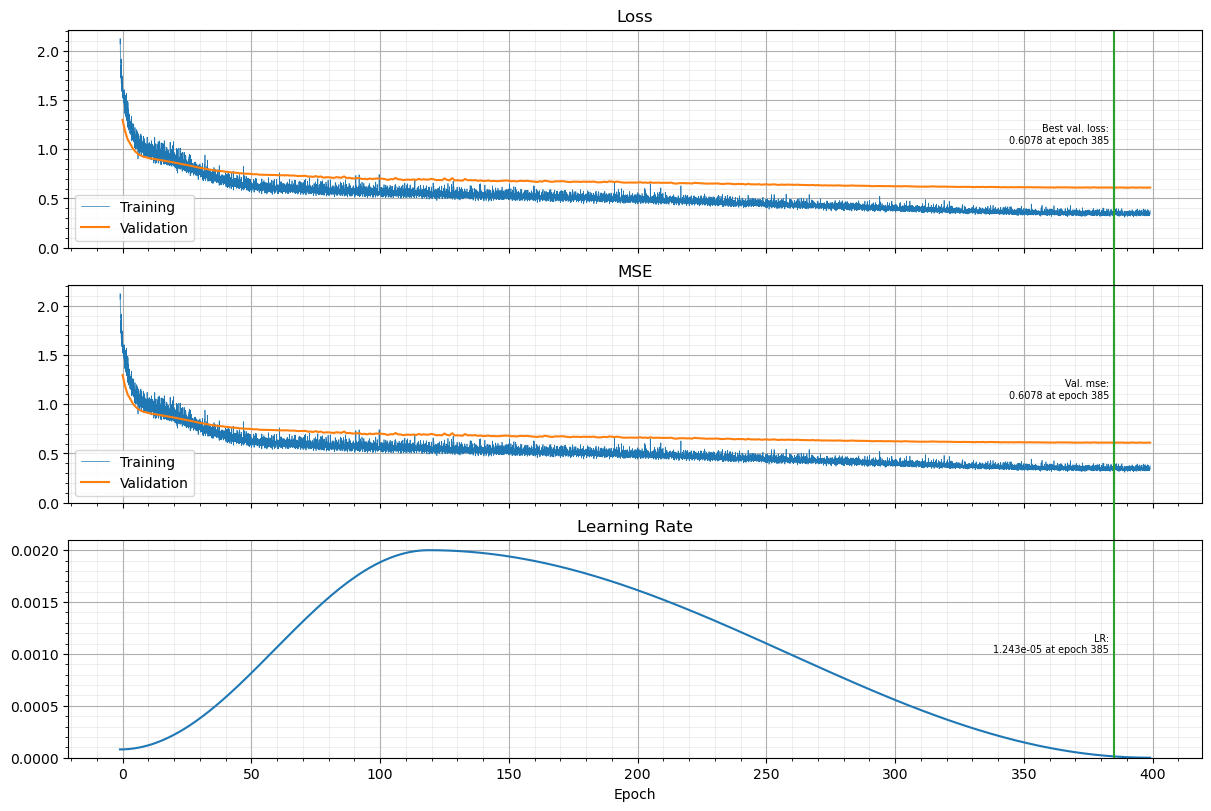

Training on sample 151674
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/46 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.79324708 | 1.79324708 | 1.30642321 | 1.30642321 | 8.0329e-05 <-- new best val loss
     1 | 1.52289514 | 1.52289514 | 1.19247009 | 1.19247009 | 8.1316e-05 <-- new best val loss
     2 | 1.37964134 | 1.37964134 | 1.11210632 | 1.11210632 | 8.296e-05  <-- new best val loss
     3 | 1.27695999 | 1.27695999 | 1.05626950 | 1.05626950 | 8.5261e-05 <-- new best val loss
     4 | 1.20116499 | 1.20116499 | 1.01168533 | 1.01168533 | 8.8216e-05 <-- new best val loss
     5 | 1.13729870 | 1.13729870 | 0.97836594 | 0.97836594 | 9.1823e-05 <-- new best val loss
     6 | 1.08498925 | 1.08498925 | 0.95432917 | 0.95432917 | 9.6081e-05 <-- new best val loss
     7 | 1.04913213 | 1.04913213 | 0.93563089 | 0.93563089 | 0.00010099 <-- new best val loss
     8 | 1.01959355 | 1.01959355 | 0.92441335 | 0.92441335 | 0.00010653 <-- new best val loss
     9 |

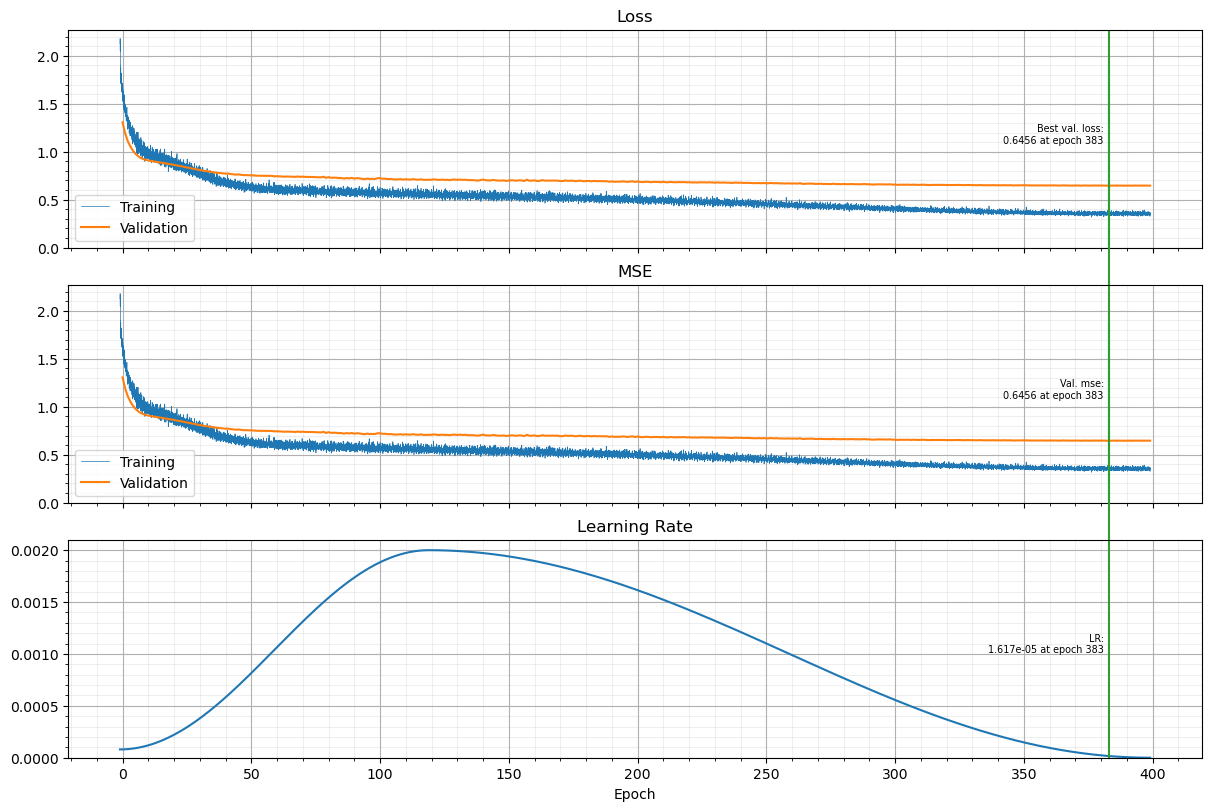

Training on sample 151675
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.79701676 | 1.79701676 | 1.28831245 | 1.28831245 | 8.0329e-05 <-- new best val loss
     1 | 1.53220882 | 1.53220882 | 1.17751165 | 1.17751165 | 8.1316e-05 <-- new best val loss
     2 | 1.39285956 | 1.39285956 | 1.11336700 | 1.11336700 | 8.296e-05  <-- new best val loss
     3 | 1.29277503 | 1.29277503 | 1.05242086 | 1.05242086 | 8.5261e-05 <-- new best val loss
     4 | 1.21362696 | 1.21362696 | 1.00606931 | 1.00606931 | 8.8216e-05 <-- new best val loss
     5 | 1.15010051 | 1.15010051 | 0.97284730 | 0.97284730 | 9.1824e-05 <-- new best val loss
     6 | 1.09819516 | 1.09819516 | 0.95063368 | 0.95063368 | 9.6081e-05 <-- new best val loss
     7 | 1.06114634 | 1.06114634 | 0.93409531 | 0.93409531 | 0.00010099 <-- new best val loss
     8 | 1.03072695 | 1.03072695 | 0.92058413 | 0.92058413 | 0.00010653 <-- new best val loss
     9 |

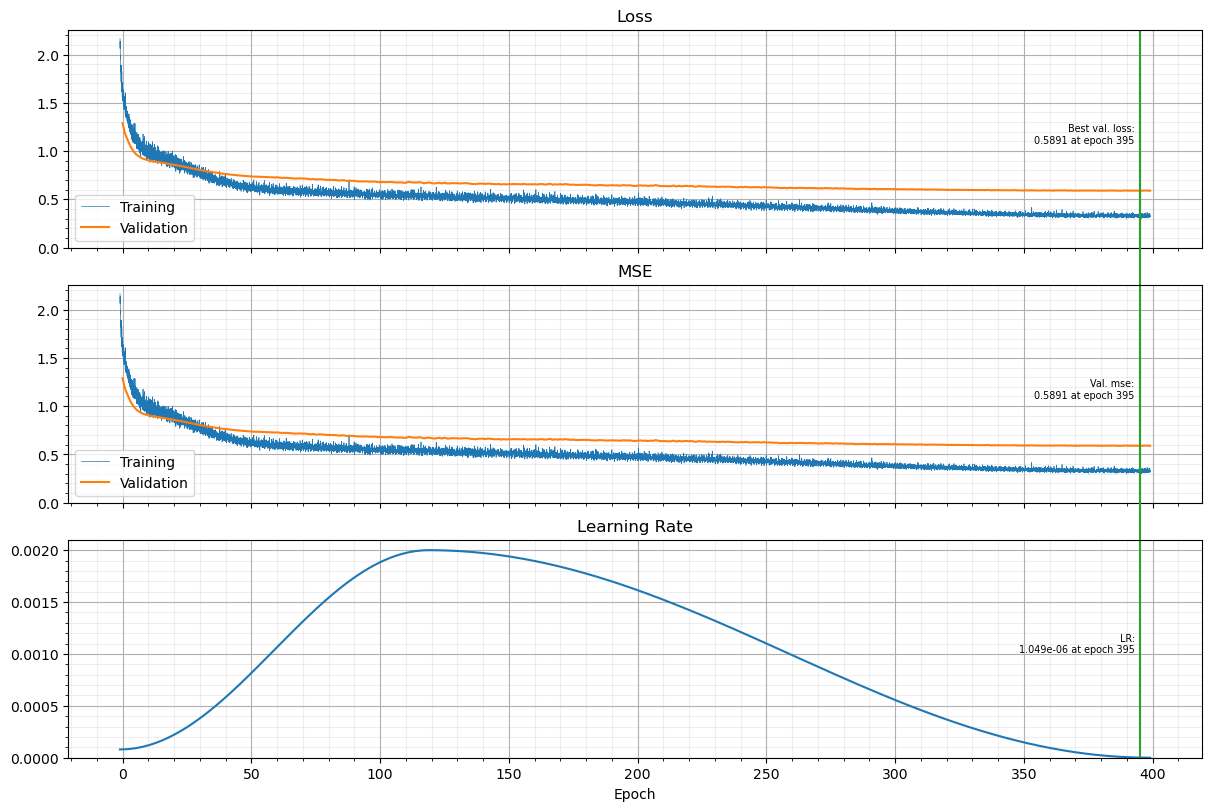

Training on sample 151676
AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bia

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.78747046 | 1.78747046 | 1.28826066 | 1.28826066 | 8.0329e-05 <-- new best val loss
     1 | 1.55239736 | 1.55239736 | 1.18798227 | 1.18798227 | 8.1316e-05 <-- new best val loss
     2 | 1.41728044 | 1.41728044 | 1.12114680 | 1.12114680 | 8.296e-05  <-- new best val loss
     3 | 1.32080904 | 1.32080904 | 1.06061824 | 1.06061824 | 8.5261e-05 <-- new best val loss
     4 | 1.24923021 | 1.24923021 | 1.02044043 | 1.02044043 | 8.8216e-05 <-- new best val loss
     5 | 1.18649566 | 1.18649566 | 0.98732797 | 0.98732797 | 9.1824e-05 <-- new best val loss
     6 | 1.13360146 | 1.13360146 | 0.96351233 | 0.96351233 | 9.6081e-05 <-- new best val loss
     7 | 1.09411411 | 1.09411411 | 0.94165908 | 0.94165908 | 0.00010099 <-- new best val loss
     8 | 1.05928810 | 1.05928810 | 0.92598503 | 0.92598503 | 0.00010653 <-- new best val loss
     9 |

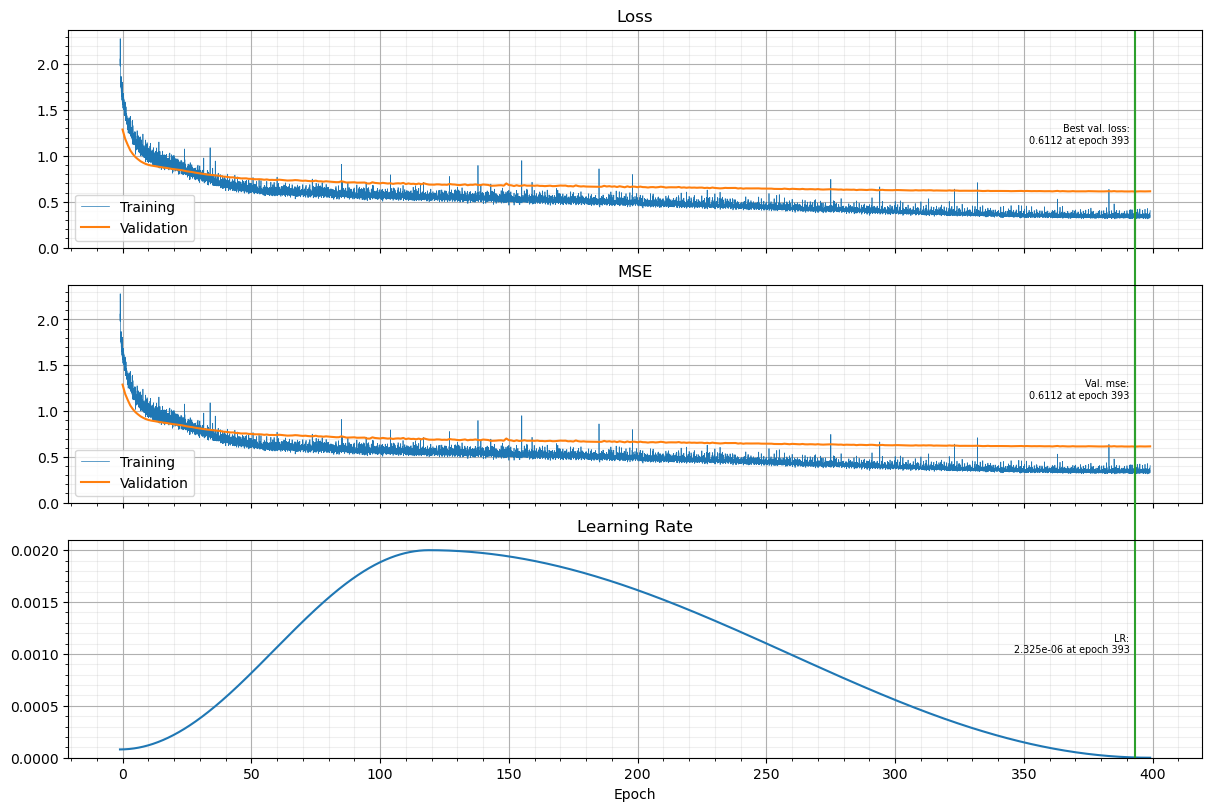

In [11]:
for sample_id in st_sample_id_l:
    print(f"Training on sample {sample_id}")
    save_folder = os.path.join(model_folder, sample_id)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Model Initialization
    model = AutoEncoder(
        inp_dim=mat_sp_d[sample_id]["train"].shape[1], **autoencoder_kwargs
    )
    model = model.to(device)
    model.apply(initialize_weights)
    print(model)

    results_history_out = train(
        model,
        save_folder,
        dataloader_target_train_d[sample_id],
        dataloader_target_val_d[sample_id],
        epochs=INITIAL_TRAIN_EPOCHS,
        **adamw_kwargs
    )


    best_checkpoint = torch.load(os.path.join(save_folder, f"final_model.pth"))
    best_epoch = best_checkpoint["epoch"]

    train_history_running = results_history_out["train"]["running"]
    val_history = results_history_out["val"]["avg"]
    plot_results(train_history_running, val_history, best_epoch, save_folder=save_folder)

In [12]:
for sample_id in st_sample_id_l:
    print(f"Testing on sample {sample_id}")
    print((np.std(mat_sp_d[sample_id]["train"], axis=0) ** 2).mean())
    best_checkpoint = torch.load(
        os.path.join(model_folder, sample_id, f"final_model.pth")
    )
    model = best_checkpoint["model"]
    model.to(device)
    model.eval()
    with torch.no_grad():
        avg_results_train, running_results_train = run_epoch(
            dataloader_target_train_d[sample_id], model
        )
        avg_results_val, running_results_val = run_epoch(
            dataloader_target_val_d[sample_id], model
        )
        avg_results_test, running_results_test = run_epoch(
            dataloader_target_test_d[sample_id], model
        )

    print(
        pd.concat(
            [
                pd.Series(avg_results_train).to_frame().T,
                pd.Series(avg_results_val).to_frame().T,
                pd.Series(avg_results_test).to_frame().T,
            ],
            keys=["train", "val", "test"],
        )
    )


Testing on sample 151507
0.98610926
             loss       mse         bs
train 0  0.238335  0.238335  63.815385
val   0  0.546776  0.546776  61.695035
test  0  0.546216  0.546216  61.695035
Testing on sample 151508
0.9916663
             loss       mse         bs
train 0  0.239872  0.239872  63.810950
val   0  0.537440  0.537440  62.767123
test  0  0.526555  0.526555  62.872437
Testing on sample 151509
0.99166393
             loss       mse         bs
train 0  0.270247  0.270247  63.870791
val   0  0.537810  0.537810  61.864301
test  0  0.549388  0.549388  61.864301
Testing on sample 151510
0.9916651
             loss       mse         bs
train 0  0.265477  0.265477  63.920421
val   0  0.545101  0.545101  62.412527
test  0  0.542941  0.542941  62.344828
Testing on sample 151669
0.994443
             loss       mse         bs
train 0  0.237285  0.237285  63.737705
val   0  0.632262  0.632262  61.737705
test  0  0.628402  0.628402  61.822888
Testing on sample 151670
0.99444425
        